**Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2021**		

**Лабораторная работа №1. Информативные признаки речевых сигналов: извлечение признаков**

**Цель работы:** изучение процедуры построения информативных акустических признаков для речевых сигналов.

**Краткое описание**: в рамках настоящей лабораторной работы требуется познакомиться с процедурами предобработки речевых сигналов и извлечения информативных признаков. В работе предлагается научиться извлекать кратковременные энергии мел-частотных полос (MFBs, mel filter banks) и мел-частотные кепстральные коэффициенты (MFCCs, mel frequency cepstral coeffitients).

**Данные**: в качестве данных для выполнения лабораторной работы предлагается использовать тестовую часть базы [VoxCeleb1](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html).

**Содержание лабораторной работы**

1. Подготовка данных для анализа.

2. Выполнение процедуры высокочастотной фильтрации (преэмфазис) речевого сигнала.

3. Вычисление акустических признаков разных видов.

4. Выполнение локальных центрирования и масштабирования акустических признаков.

5. Построение распределений первых трёх компонент полученных акустических признаков для мужских и женских голосов.

In [1]:
# IPython extension to reload modules before executing user code
%load_ext autoreload
%autoreload 2

# Import of modules
import os
import sys

sys.path.append(os.path.realpath('..'))

from common import download_dataset, extract_dataset

from math import sqrt, pi
from scipy.fftpack import dct

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist, plot, show, grid, title, xlabel, ylabel, legend, axis, imshow

from mpl_toolkits.axes_grid1 import make_axes_locatable

from skimage.morphology import opening, closing
from torchaudio.transforms import Resample
from multiprocessing import Pool
import torchaudio

from exercises_blank import split_meta_line, preemphasis, framing, power_spectrum 
from exercises_blank import compute_fbank_filters, compute_fbanks_features, compute_mfcc, mvn_floating

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



**1. Подготовка данных для анализа**

В ходе выполнения лабораторной работы необходимы данные для осуществления процедуры вычисления акустических признаков. Возьмём в качестве этих данных несколько звукозаписей голосов людей мужского и женского пола, сохраненных в формат *wav*, выбранных из корпуса [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip). Данный корпус содержит 4,874 звукозаписи (частота дискретизации равна 16кГц) 40 дикторов мужского и женского пола, разговаривающих на английском языке.

В рамках настоящего пункта требуется выполнить загрузку и распаковку звуковых wav-файлов из корпуса VoxCeleb1 test set.

![Рисунок 1](https://analyticsindiamag.com/wp-content/uploads/2020/12/image.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [2]:
# # Download VoxCeleb1 (test set)
# with open('../data/lists/datasets.txt', 'r') as f:
#     lines = f.readlines()

# download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

In [3]:
# # Extract VoxCeleb1 test set
# extract_dataset(save_path='../data/voxceleb1_test', fname='../data/vox1_test_wav.zip')

**2. Выполнение процедуры высокочастотной фильтрации (преэмфазис) речевого сигнала**

В рамках настоящего пункта предлагается изучить процедуру предобработки речевых сигналов, получившую название преэмфазис. *Преэмфазис (pre-emphasis)* – применение фильтра верхних частот к сигналу до процедуры извлечения признаков для того, чтобы компенсировать тот факт, что обычно вокализованная речь содержит на низких частотах намного больше энергии, чем невокализованная речь на высоких. Обозначим через $x(n)$ обрабатываемый сигнал, а через $y(n)$ результат обработки, тогда процедура преэмфазиса может быть описана с помощью следующего выражения:

$$y(n) = x(n) + \alpha x(n-1).$$

Выражение выше представляет собой *линейное разностное уравнение с постоянными коэффициентами* и позволяет описать процедуру работы *нерекурсивного фильтра первого порядка с конечной импульсной характеристикой*. Параметр $\alpha$ является единственным параметром рассматриваемого фильтра. В случае, когда параметр $\alpha$ является отрицательным, рассматриваемый фильтр обладает свойствами *фильтра верхних частот*. Для выполнения процедуры преэмфазиса обычно параметр $\alpha = -0.97$.

В рамках настоящего пункта требуется:

1. Загрузить анализируемый речевой сигнал.

2. Выполнить процедуру преэмфазиса по отношению к загруженному речевому сигналу.

3. Сравнить спектры речевых сигналов до и после процедуры преэмфазиса.

**2.1. Загрузка файла. Осцилограмма. Спектрограмма.** Для начала, давайте, загрузим пример речевого сигнала в память компьютера. Сейчас существует достаточно много библиотек для работы со звуковыми файлами (scipy.io.wavfile, soundfile, torchaudio и т.п.). Можно использовать любую из них для работы. Мы остановим свой выбор на torchaudio для удобства и системности дальнейшего изложения. В папке **./metadata/** представлен файл **meta.txt** со списком файлов, которые мы предлагаем использовать в данной лабораторной работе.  Файл **meta.txt** имеет достаточно простой формат строк: 

Speaker_ID Gender Path  
id10271 m ../data/voxceleb1_test/wav/id10271/1gtz-CUIygI/00006.wav  
id10272 m ../data/voxceleb1_test/wav/id10272/dkN2DIBrXqQ/00008.wav  
id10273 m ../data/voxceleb1_test/wav/id10273/8cfyJEV7hP8/00002.wav  
...  

Распарсим файл с метаинформацией и загрузим первый по списку файл.  

In [4]:
path_to_meta = "./metadata/meta.txt"
from exercises_blank import split_meta_line
p = Pool(1)
with open(path_to_meta, 'r') as f:
     list_lines = f.readlines()
speaker_ids, genders, paths = zip(*p.map(split_meta_line, list_lines[1:]))

path_to_wav = paths[0]

In [5]:
print("Loading of {}".format(path_to_wav))
print([path_to_wav])
# Load signal
signal, sample_rate = torchaudio.load(path_to_wav)
signal = signal.numpy().squeeze(axis=0)
signal = signal/np.abs(signal).max()

print("Done!")

Loading of ../data/voxceleb1_test/wav/id10271/1gtz-CUIygI/00006.wav
['../data/voxceleb1_test/wav/id10271/1gtz-CUIygI/00006.wav']
Done!


Построим осцилограмму и спектрограмму первых 3.5 секунд речевого сигнала.

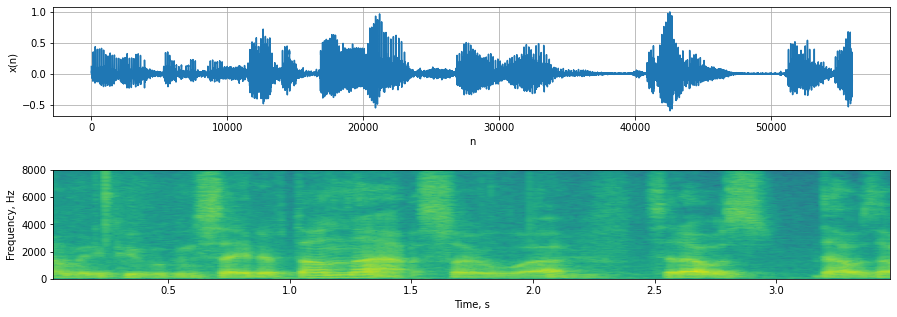

In [6]:
signal = signal[0:int(3.5 * sample_rate)]  # keep the first 3.5 seconds

plt.figure(1, figsize=(15, 5))
plot_a = plt.subplot(211)
plt.subplots_adjust(wspace=0, hspace=0.5)

plot_a.plot(signal)
plot_a.set_xlabel('n')
plot_a.set_ylabel('x(n)')
plot_a.grid()

plot_b = plt.subplot(212)
plot_b.specgram(signal, NFFT=1024, Fs=sample_rate, noverlap=900)
plot_b.set_xlabel('Time, s')
plot_b.set_ylabel('Frequency, Hz')
plt.show()

**2.2. Выполнение процедуры преэмфазиса по отношению к загруженному речевому сигналу. Сравнение спектров**

In [7]:
emphasized_signal = preemphasis(signal)

Построим спектрограммы обработанного и «сырого» сигналов.

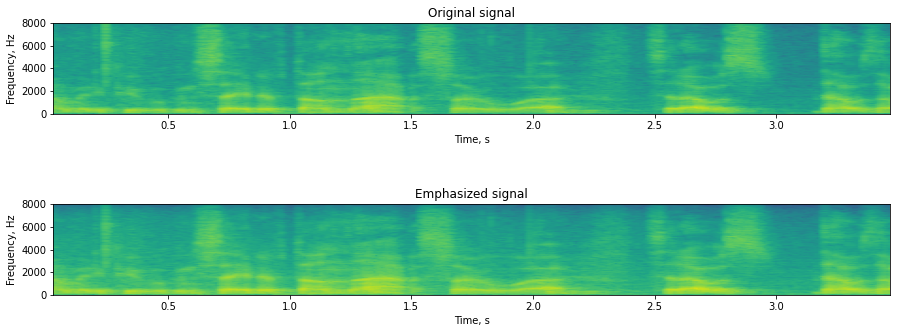

In [8]:
plt.figure(figsize=(15, 5))
plot_a = plt.subplot(211)
plt.subplots_adjust(wspace=0, hspace=1)

plot_a.specgram(signal, NFFT=1024, Fs=sample_rate, noverlap=900)
plot_a.set_xlabel('Time, s')
plot_a.set_ylabel('Frequency, Hz')
plot_a.title.set_text('Original signal')

plot_b = plt.subplot(212)
plot_b.specgram(emphasized_signal, NFFT=1024, Fs=sample_rate, noverlap=900)
plot_b.set_xlabel('Time, s')
plot_b.set_ylabel('Frequency, Hz')
plot_b.title.set_text('Emphasized signal')
plt.show()

**3. Вычисление акустических признаков разных видов**

Работа современных систем голосовой биометрии, как правило, является основанной на использовании акустических признаков. *Акустические признаки* являются формой представления речевого сигнала в частотно-временной области. Возможным примером акустических признаков является *спектрограмма* сигнала, которую можно вычислить с использованием *оконного преобразования Фурье*. Однако, использование спектрограммы на практике не является выгодным, в частности, из-за её большого разрешения по частоте. Поэтому возможным вариантом для построения акустических признаков могут являться: *логарифмов энергий на выходе мел-банка фильтров*, *мел-частотные кепстральные коэффициенты размерности* и т.п.

В рамках настоящего пункта предлагается вычислить логарифмы энергий на выходе мел-банка фильтров размерности 40 и мел-частотные кепстральные коэффициенты размерности 23. Для выполнения задания выше можно воспользоваться следующим алгоритмом:

1. Представить обрабатываемый речевой сигнал в виде набора фреймов с использованием *окна Хэмминга* (размер окна можно выбрать равным 25мс, а шаг окна – 10мс).

2. Вычислить одномерный спектр Фурье по отношению к каждому из фреймов.

3. Рассчитать мел-банк фильтров.

4. Перемножить квадрат *амплитудно-частотной характеристики (АЧХ)* каждого фильтра со спектром мощности каждого из фреймов ⁡и просуммировать коэффициенты получившихся спектров, рассчитав энергии внутри соответствующих полос банка фильтров.

5. Вычислить логарифм от значений энергий на предыдущем шаге. *На этом шаге формируется первый тип акустических признаков.*

6. Вычислить дискретное косинусное преобразование от логарифмов коэффициентов. *На этом этапе формируются мел-частотные кепстральные коэффициенты.*

Подробное описание процедуры вычисления акустических признаков можно найти по следующей [ссылке](http://practicalcryptography.com/miscellaneous/).


**3.1. Представление  речевого сигнала в виде набора фреймов с использованием окна Хэмминга**

In [9]:
frames = framing(emphasized_signal)

# print(frames[-1])
print("Features shape is: {}".format(frames.shape))

Features shape is: (348, 400)


Произведем расчет спектра мощности для каждого фрэйма.

In [10]:
pow_frames = power_spectrum(frames)

In [11]:
pow_frames.shape

(348, 257)

**3.2. Рассчёт мел-банка фильтров**


In [12]:
fbank = compute_fbank_filters(nfilt=40, sample_rate=16000, NFFT=512)

Построим квадраты АЧХ полученных фильтров.

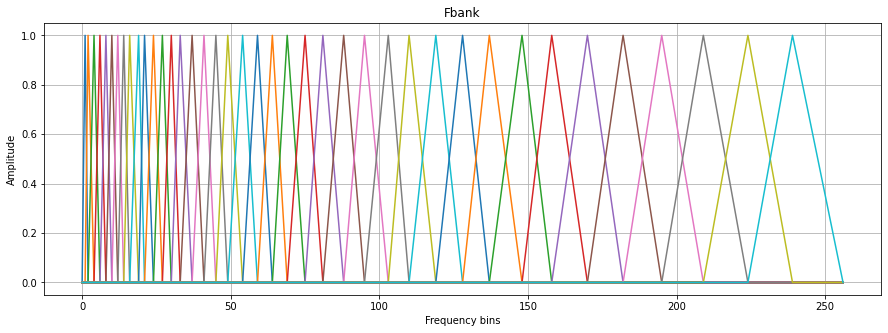

In [13]:
plt.figure(figsize=(15, 5))
plot_a = plt.subplot()
plt.subplots_adjust(wspace=0, hspace=1)

nfilt = fbank.shape[0]
for k in range(nfilt):
    plot_a.plot(fbank[k,:])
    
plot_a.set_xlabel('Frequency bins')
plot_a.set_ylabel('Amplitude')
plot_a.title.set_text('Fbank')
plot_a.grid()
plt.show()

**3.3. Рассчёт энергии сигнала внутри соответствующих полос банка фильтров**

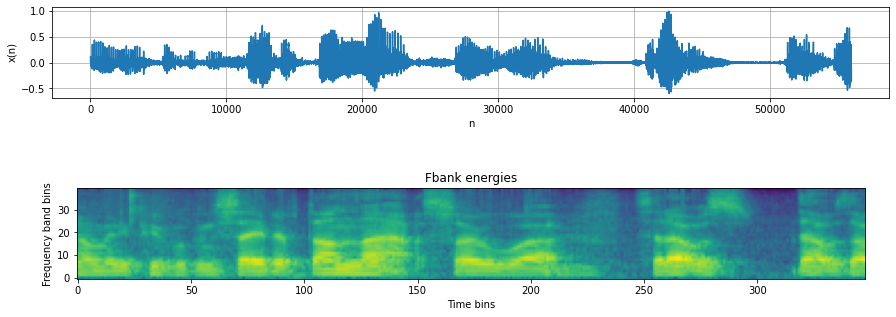

In [14]:
filter_banks_features = compute_fbanks_features(pow_frames, fbank)

plt.figure(3, figsize=(15, 5))
plt.subplots_adjust(wspace=0, hspace=1)

plot_a = plt.subplot(211)
plot_a.plot(signal)
plot_a.set_xlabel('n')
plot_a.set_ylabel('x(n)')
plot_a.grid()

plot_b = plt.subplot(212)
plot_b.imshow(filter_banks_features.T, origin='lower')

plot_b.set_xlabel('Time bins')
plot_b.set_ylabel('Frequency band bins')
plot_b.title.set_text('Fbank energies')
plt.show()

**3.4. Вычисление дискретного косинусного преобразования от логарифмов энергий**

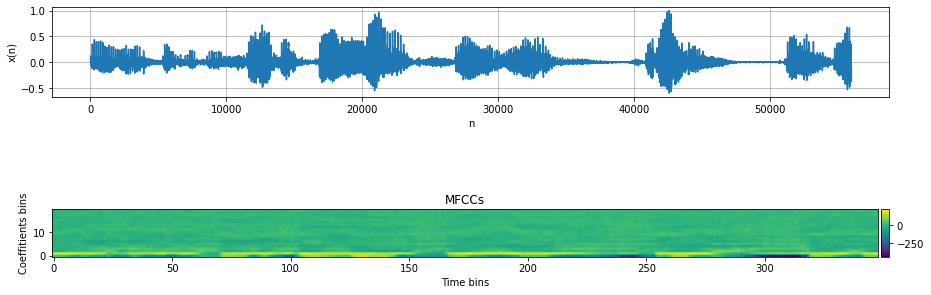

In [15]:
mfcc = compute_mfcc(filter_banks_features, num_ceps=20)

fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0, hspace=1)
plot_a = plt.subplot(211)
plot_a.plot(signal)
plot_a.set_xlabel('n')
plot_a.set_ylabel('x(n)')
plot_a.grid()

plot_b = plt.subplot(212)
im = plot_b.imshow(mfcc.T, origin='lower')

divider = make_axes_locatable(plot_b)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(im, cax=cax)

plot_b.set_xlabel('Time bins')
plot_b.set_ylabel('Coeffitients bins')
plot_b.title.set_text('MFCCs')
plt.show()

**4. Выполнение локальных центрирования и масштабирования акустических признаков**

Канал связи может вносит некоторое смещение в захваченный сигнал (микрофон может не иметь равномерную АЧХ, изменения в усилении
сигнал приводят к вычислению различных акустических признаков даже для одного и того же куска речи). Канальный эффект можно промоделировать с использованием линейного инвариантного к сдвигу фильтра (ЛИС-фильтра) и учесть при корректировке значений акустических признаков. Данная процедура получила название *процедуры нормализации*.

Идея выполнения процедуры нормализации состоит в вычислении среднего вектора наблюдаемых акустических признаков и центрирования всех векторов акустических признаков произнесения на это среднее. Процедура нормализации может быть выполнена несколькими различными способами:

1. Локально по произнесению (вычисляем среднее в некоторой окрестности (обычно 300 фреймов) каждого фрейма стека признаков и нормализуем на них этот фрейм).

2. Глобально по произнесению (вычисляем среднее один раз по всей сессии и нормализуем на них все фреймы сессии).

3. глобально по базе данных (вычисляем среднее общее для всех сессий в тренировочной базе данных и нормализуем на них все фреймы всех сессий).

Иногда процедура нормализации сопровождается процедурой *масштабирования акустических признаков*. Процедура масштабирования признаков может быть выполнена теми же способами, что и процедура нормализации. Отличие процедуры масштабирования признаков от процедуры нормализации состоит в том, что при её выполнении необходимо вычислить не средний вектор акустических признаков, а вектор среднеквадратического отклонения, на который необходимо поэлементно разделить каждый нормализованный вектор акустических признаков некоторого произнесения.

Предполагая, что набор акустических признаков до выполнения процедур нормализации и масштабирования был задан функцией $|X(k, m)|$, а после выполнения данных процедур – $|X_{norm}(k, m)|$, запишем следующее выражение:

$$|X_{norm}(k, m)| = \frac{|X(k, m)| - m_X}{\sigma_X},$$

где $m_X$ – это средний вектор акустических признаков, $\sigma_X$ – это вектор среднеквадратического отклонения акустических признаков, $k$ и $m$ имеют суть частоты и времени ($k$ – номер спектральной составляющей, а $m$ – это номер фрейма).

В рамках настоящего пункта требуется выполнить процедуры нормализации и масштабирования по отношению к логарифмам энергий на выходе банка фильтров и мел-частотным кепстральным коэффициентам, вычисленным для некоторой звукозаписи.

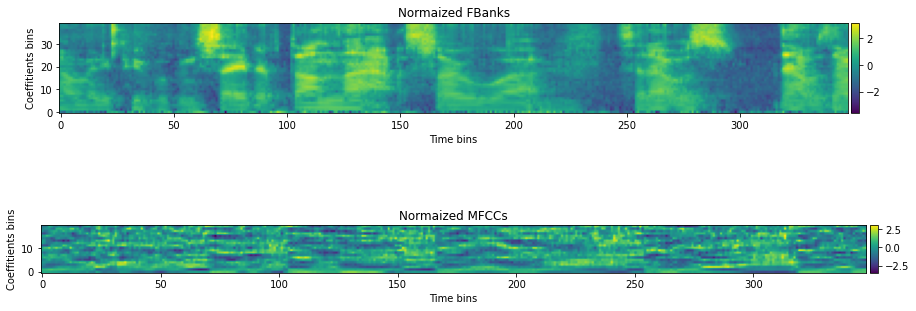

In [16]:
mfcc_cmvn = mvn_floating(mfcc, 150, 150)
filter_banks_features_mvn = mvn_floating(filter_banks_features, 150, 150)

fig = plt.figure(3, figsize=(15, 5))
plt.subplots_adjust(wspace=0, hspace=1)

plot_b = plt.subplot(211)
im_b = plot_b.imshow(filter_banks_features_mvn.T, origin='lower')
divider = make_axes_locatable(plot_b)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(im_b, cax=cax)
plot_b.set_xlabel('Time bins')
plot_b.set_ylabel('Coeffitients bins')
plot_b.title.set_text('Normaized FBanks')

plot_с = plt.subplot(212)
im_c = plot_с.imshow(mfcc_cmvn.T, origin='lower')
divider = make_axes_locatable(plot_с)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(im_c, cax=cax)
plot_с.set_xlabel('Time bins')
plot_с.set_ylabel('Coeffitients bins')
plot_с.title.set_text('Normaized MFCCs')
plt.show()

**5. Построение распределений первых трёх компонент полученных акустических признаков для мужских и женских голосов**

Для того, чтобы грубо проверить правильность расчёта акустических признаков выше, построим гистограммы распределения первых трёх компонент логарифмов энергий на выходе банка фильтров и мел-частотных кепстральных коэффициентов по некоторой базе данных. Рассмотрим в качестве этой базы звукозаписи мужских и женских голосов дикторов, список которых представлен в **./metadata/meta.txt**. В указанном файле перечислен список из 20 звукозаписей (10 для дикторов женского пола и 10 для дикторов мужского пола) из базы VoxCeleb1 test set с указанием пути до них, идентификационного номера диктора и пола диктора (символ **f** означает женский пол, а символ **m** означает мужской пол).

Используя звукозаписи, список которых перечислен в **./metadata/meta.txt**, выполнить построение гистограмм распределения первых 3 компонент логарифмов энергий на выходе банка фильтров и мел-частотных кепстральных коэффициентов отдельно для базы мужских и женских голосов.

(18908, 40)
(18604, 40)
(18908, 20)
(18604, 20)


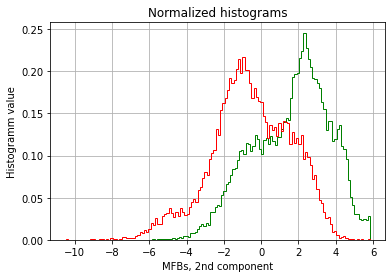

In [17]:
fbank = compute_fbank_filters(nfilt=40, sample_rate=16000, NFFT=512)

def compute_feats(signal):
    # Function to compute mel frequency cepstral coefficient
    
    emphasized_signal = preemphasis(signal)
    frames = framing(emphasized_signal)
    pow_frames = power_spectrum(frames)
    filter_banks_features = compute_fbanks_features(pow_frames, fbank)
    mfcc = compute_mfcc(filter_banks_features, num_ceps=20)
    
    # mfcc = mvn_floating(mfcc, 150, 150)
    # filter_banks_features = mvn_floating(filter_banks_features, 150, 150)
    
    return filter_banks_features, mfcc

male_fb_features = []
female_fb_features = []
male_mfcc_features = []
female_mfcc_features = []

for (path_to_wav, gender) in zip(paths, genders):
    # Load signal
    signal, sample_rate = torchaudio.load(path_to_wav)
    signal = signal.numpy().squeeze(axis=0)
    signal = signal/np.abs(signal).max()
    
    # Processing
    filter_banks_mvn, mfcc_cmvn = compute_feats(signal)
    if gender == 'm':
        male_fb_features.append(filter_banks_mvn)
        male_mfcc_features.append(mfcc_cmvn)
    else:
        female_fb_features.append(filter_banks_mvn) 
        female_mfcc_features.append(mfcc_cmvn)
    
male_fb_features = np.concatenate(male_fb_features)
print(male_fb_features.shape)

female_fb_features = np.concatenate(female_fb_features)
print(female_fb_features.shape)

male_mfcc_features = np.concatenate(male_mfcc_features)
print(male_mfcc_features.shape)

female_mfcc_features = np.concatenate(female_mfcc_features)
print(female_mfcc_features.shape)


comp_number = 1
coeff1_male = male_fb_features[:, comp_number]
coeff1_female = female_fb_features[:, comp_number]

min_coeff1 = min(coeff1_male.min(), coeff1_female.min())
max_coeff1 = min(coeff1_male.max(), coeff1_female.max())

hist(coeff1_male,   int(sqrt(len(coeff1_male))),   histtype='step', color='green', range=(min_coeff1, max_coeff1), density=1)
hist(coeff1_female, int(sqrt(len(coeff1_female))), histtype='step', color='red',   range=(min_coeff1, max_coeff1), density=1)
xlabel('MFBs, 2nd component'); ylabel('Histogramm value'); title('Normalized histograms'); grid(); show()

**6. Контрольные вопросы**

1. Какие способы представления сигналов существуют? аналоговый, дискретный, квантовый, цифровой

2. Что такое спектр Фурье (амплитудный и фазовый)? 

спектр - распределение сигнала по частотам.
амплитудный спектр - модуль комплексного спектра
фазовый - фаза комплексного спектра  

3. Что такое оконное преобразование Фурье?
оконное преобразование Фурье - преобразование Фурье взятое от сигнала домноженного на окнную функцию, которая также сдвигается. получается частотно-временная арактеристика. 

4. Что такое спектрограмма?
Спектрограмма — изображение, показывающее зависимость спектральной плотности мощности сигнала от времени.
5. Как выполнить процедуру преэмфазиса?
пропустить сигнал через фвч
6. Описать процедуру вычисления акустических признаков.
1) разбить сигнал на фреймы
2) рассчиать фильтр банки
3) рассчитать энергию сигналу внутри полосы соответствующей фильтру
4) взять косинус преобразование
7. Для каких целей выполняются процедуры нормализации и масштабирования акустических признаков?
Для центрирования признаков, сделав их инвариантными к ско и среднему.

**7. Список литературы**

1. Hayes M.H. Schaum’s outlines of digital signal processing. McGraw-Hill, 2011 ([ссылка](http://index-of.co.uk/DSP-Collection/Hayes,%20M.H.,%20Schaum's%20Outline%20of%20Digital%20Signal%20Processing,%20McGraw-Hill,%201999.pdf)).

2. Beigi H. Fundamentals of speaker recogniton. Springer, 2011 ([ссылка](https://www.springer.com/gp/book/9780387775913)).

3. Černocký H. Voice biometry standard proposal // Interspeech 2015, Dresden, Germany, 2015 ([ссылка](https://voicebiometry.org/)).